# Project 3  - Federated Semantic Segmentation for self-driving cars
The porpouse of the project is to familiarize with Federated Learning, which is a possible solution to perserve the privacy of the users while training a neural network in the context of Semantic Segmentation applied to surrounding recogniction for autonomous vehicles.

## Imports
In this first section, we import all the packages that we need in order for the code to work. If you want, you can create a virtual environment and install all the packages needed with the `requirements.txt` file.

First of all, we load the IPython extension "autoreload", which allows us to modify the source code without the need to restart the kernel:

In [1]:
%load_ext autoreload
%autoreload 2

We tried to use as much as possible Google Colab in orded to exploit it's GPU computational power, but with the free version we were costantly timed out for the day and so we decided to switch to a local GPU if Google Colab was not available. 

The following code configure Google Colab in case the notebook was runned there.

In [2]:
try:
    from google.colab import drive 
    drive.mount('/content/drive')
    %pip install wandb
    %cd /content/drive/MyDrive/DAAI
    IN_COLAB = True
except:
    IN_COLAB = False

Then, we imported the modules that we needed. Some are standard python - or pytorch - modules, some are taken (and modified, if necessary) from public papers and some are written by us. You can find the complete references of the papers and code used in the official report. 

In [3]:
import os, torch, wandb
import matplotlib.pyplot as plt
from dataset.cityscapes import Cityscapes
from dataset.gta5 import Gta5
from clients.client import Client
from clients.student import StudentClient
from server.server import Server
from modules.bisenetv2 import BiSeNetV2
import dataset.transform as CT
from dataset.utils import *
from utils.style_transfer import StyleAugment
from tqdm import tqdm

We decided to use WandB to log our experiments:

In [4]:
wandb.login()

wandb: Currently logged in as: stefavitra. Use `wandb login --relogin` to force relogin


True

<a id='configuration'></a>
## Configuration
In this section we set all the constants and parameters that we use in the following steps. Amongst the others, we set the hyperparameters for the neural networks (centralized and FL), the paths to the data, the configuration dictionary for the logger and the combination of transform used to train the network. Those are the custom transform for semantic segmentation, as suggested.


In [4]:
CITYSCAPES_PATH = os.path.join('data', 'Cityscapes')
GTA5_PATH = os.path.join('data', 'GTA5')

HEIGHT, WIDTH = 512, 1024

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # 'cuda' or 'cpu' or 'mps'


# CENTRALIZED BASELINE ---------------------------------------------------------------------------------------------------------

NUM_CLASSES = 19 # 19 classes defined in dataset/cityscapes

BATCH_SIZE = 4  # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 100e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4  # Regularization, you can keep this at the default

NUM_EPOCHS = 30     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.5        # Multiplicative factor for learning rate step-down (0.1 default)

hypers = {"LR": LR,
         "MOMENTUM": MOMENTUM,
         "WEIGHT_DECAY": WEIGHT_DECAY,
         "STEP_SIZE": STEP_SIZE,
         "GAMMA": GAMMA
         }

wandb_config = {"initial_lr": LR,
                "step_size": STEP_SIZE,
                "step_down_gamma": GAMMA,
                "batch_size": BATCH_SIZE,
                "epochs": NUM_EPOCHS
               }

# FEDERATED LEARNING + SEMANTIC SEGMENTATION --------------------------------------------------------------------------------------

BATCH_SIZE_FLSS = 2  # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR_FLSS = 100e-3            # The initial Learning Rate
MOMENTUM_FLSS = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY_FLSS = 5e-4  # Regularization, you can keep this at the default

NUM_EPOCHS_FLSS = 3    # Total number of training epochs (iterations over dataset)
STEP_SIZE_FLSS = 1     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA_FLSS = 0.5         # Multiplicative factor for learning rate step-down (0.1 default)
NUM_ROUNDS = 10
NUM_CLIENTS = 50
CLIENTS_PER_ROUND = 10

HETEROGENEOUS = False
FDA_WINDOW_SIZE = 32 # Half the size of FDA window

hypers_flss = {"LR": LR_FLSS,
         "MOMENTUM": MOMENTUM_FLSS,
         "WEIGHT_DECAY": WEIGHT_DECAY_FLSS,
         "STEP_SIZE": STEP_SIZE_FLSS,
         "GAMMA": GAMMA_FLSS
         }

wandb_config_flss = {
        "initial_lr": LR_FLSS,
        "step_size": STEP_SIZE_FLSS,
        "step_down_gamma": GAMMA_FLSS,
        "batch_size": BATCH_SIZE_FLSS,
        "epochs": NUM_ROUNDS,
        "split": "heterogeneous" if HETEROGENEOUS else "uniform"
}

# AUGMENTATION

train_transform = CT.Compose(
    [CT.Resize([HEIGHT, WIDTH]),
     CT.RandomHorizontalFlip(),
     CT.ToTensor(),
     
    ])

test_transform = CT.Compose(
    [CT.Resize([HEIGHT, WIDTH]),
     CT.RandomHorizontalFlip(),
     CT.ToTensor()
    ])

<a id='datasets'></a>
## 1. Partition Cityscapes into Train and Test
First of all, we need to generate the datasets that are gonna be used for our experiments. In particular, with `DSA` and `DSB` we indicate the partition A and partition B referred in the project paper. For what concernes the partition A, we first check if it already exists a `.txt` file containing the images. If it does, we load it; if it doesn't, we generate one according to the project paper and saves it in a `.txt` file. This is done in order to have the same dataset thorugh all the following steps.

You can find the code for all the classes and methods related to the dataset in the folder "dataset". In detail, we use the methods in "utils" to generate a list from a `.txt` file and one for the inverse operation. This is because we designed the `Cityscapes` class (in dataset/cityscapes.py) to be built starting from a list of image paths. 

In [5]:
# Dataset A - Loading the split if it exists, creating otherwise
path_testA = os.path.join(CITYSCAPES_PATH, 'testA.txt')
path_trainA = os.path.join(CITYSCAPES_PATH, 'trainA.txt')

if os.path.isfile(path_testA) and os.path.isfile(path_trainA):
    testA = txt2list(os.path.join(CITYSCAPES_PATH, 'testA.txt'))
    trainA = txt2list(os.path.join(CITYSCAPES_PATH, 'trainA.txt'))
    print("Dataset A found and loaded.")

else:
    testA, trainA = random_split(os.path.join(CITYSCAPES_PATH, 'images'))
    list2txt(testA, path_testA)
    list2txt(trainA, path_trainA)
    print("Dataset A not found - Generated one instead.")


DSA_train = Cityscapes(CITYSCAPES_PATH, trainA, transform=train_transform, cl19=True)
DSA_test = Cityscapes(CITYSCAPES_PATH, testA, transform=test_transform, cl19=True)

# Dataset B
trainB = txt2list(os.path.join(CITYSCAPES_PATH, 'train.txt'))
testB = txt2list(os.path.join(CITYSCAPES_PATH, 'val.txt'))

DSB_train = Cityscapes(CITYSCAPES_PATH, trainB, transform=train_transform, cl19=True)
DSB_test = Cityscapes(CITYSCAPES_PATH, testB, transform=test_transform, cl19=True)




Dataset A found and loaded.


<a id='centralized'></a>
## 2. Centralized Baseline
In this step, we train centralized baselines for both the A/B partitions that is going to be used for the next steps. To do so, we used, as suggested, the BiSeNet V2 network, which we loaded from `modules.bisenetv2`. 

We used `torch.cuda.empty_cache()` due to the limited memory in the local GPU.

In [6]:
# CNN Client
torch.cuda.empty_cache()
net = BiSeNetV2(NUM_CLASSES, output_aux = False)
net.to(DEVICE);

Now we are ready to run the first experiment and train the centralized network. In order to do so, having already in mind the Federated Learning setting, we decided to build a `Client` class and use that to train the network.

The `Client` class is constructed from a network and a dataset on which the network will be trained. The dataloader is constructed automatically inside the client from the dataset. Moreover, it contains method to train and test the model, and also to save and load checkpoints. You can find the source code in `clients.client`.

Since we use WandB as datalogger, we initialize a run and finish it after the network is trained:

In [ ]:
wandb.init(project="baseline_DSA", config=wandb_config)
baseline_DSA = Client(f"{wandb.run.name}-baseline-DSA", DSA_train, net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, num_classes=NUM_CLASSES)
baseline_DSA.train(NUM_EPOCHS, hypers)
wandb.finish()

wandb: Currently logged in as: stefavitra. Use `wandb login --relogin` to force relogin


ID: balmy-pond-19-baseline-DSA - Training...


Epoch:   0%|                                             | 0/30 [00:00<?, ?it/s]/home/stefano/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
Epoch:  97%|███████████████████████████████▉ | 29/30 [1:06:24<02:13, 133.73s/it]

We follow the same procedure for the partition B:

In [ ]:
torch.cuda.empty_cache()
net = BiSeNetV2(NUM_CLASSES, output_aux = True)
net.to(DEVICE);

wandb.init(project="baseline_DSB", config=wandb_config)
baseline_DSB = Client(f"{wandb.run.name}-baseline-DSB", DSB_train, net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, num_classes=NUM_CLASSES)
baseline_DSB.train(NUM_EPOCHS, hypers)
wandb.finish()

We ran this section several times, changing the hyperparameters and augmentation in order to find the best combination. You can find the best combination and the reasoning behind the choice in the official report.

We can test the two best networks on the corrisponding partitions:

Loaded model: saved/centralized-DSA.pth.


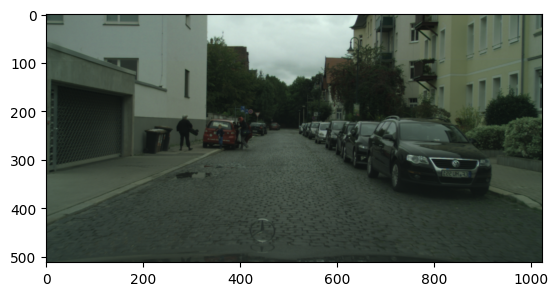

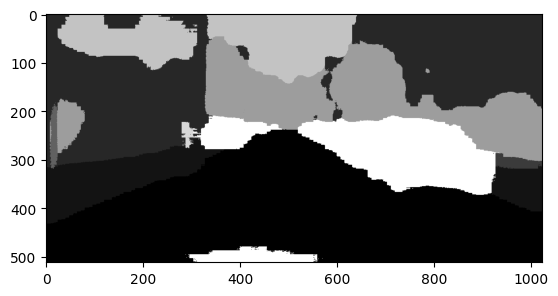

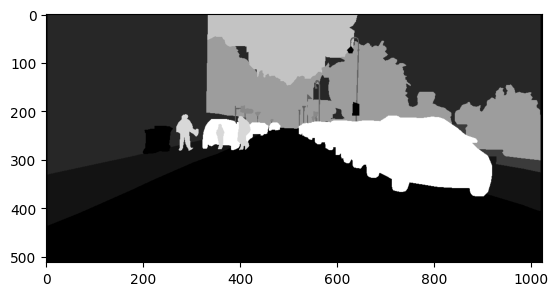

Accuracy: 0.3686592643498095


In [16]:
LOAD_PATH = "saved/centralized-DSA.pth" # "saved/centralized-DSA.pth"; "saved/centralized-DSB.pth"

torch.cuda.empty_cache()
test_net = BiSeNetV2(NUM_CLASSES, output_aux = True)
test_net.to(DEVICE)

test_client = Client(f"test_client", DSA_test, test_net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, autosave=False)
test_client.load_model(LOAD_PATH)

accuracy = test_client.test()
print(f"Accuracy: {accuracy['Mean IoU']}")

<a id='step3'></a>
## 3. Federated Semantic Segmentation experiments
In this section, we run our first experiment combining Federated Learning and Semantic Segmentation.

As suggested in the project paper, we tried to address the problems of Statistical Heterogeneity and Domain Generalization by distribuiting the data across the clients according to heterogeneous and uniform split. In any case, the test client contains the test dataset built in [step 1](#datasets).

For code readability porpouses, the split is decided in the [configuration section](#configuration) and the experiment is runned different times, saving in WandB wether the split is heterogeneous or uniform.

In [18]:
if HETEROGENEOUS:
    split_A = heterogeneous_split(DSA_train, NUM_CLIENTS)
    split_B = heterogeneous_split(DSB_train, NUM_CLIENTS)
    
else:
    split_A = uniform_split(DSA_train, NUM_CLIENTS)
    split_B = uniform_split(DSB_train, NUM_CLIENTS)

The procedure is similar to the one adopted in the [centralized baseline](#centralized), but in that case we used the `Server` class, available in `server.server`, to coordinate the training between the clients, exploiting to the Federated Averaging algorithm.

In particular, when calling the `Server.fedAvg()` method, the server will:
1. Select randomly a set of clients between the ones available
1. Request an update to the set of clients sending the global model, in which each client will:
    1. Train for a defined number of epochs on the local dataset
    1. Return the updated local model parameters
1. Average the updated local models through Federated Averaging algorithm
1. Update the global model
1. Repeat for a defined number of rounds



In [19]:
torch.cuda.empty_cache()
net_flss = BiSeNetV2(NUM_CLASSES, output_aux = True)
net_flss.to(DEVICE)

clients = []
for i, images_paths in enumerate(split_A):
    client_dataset = Cityscapes(CITYSCAPES_PATH, images_paths, transform=train_transform, cl19=True)
    client = Client(f"c{i}", client_dataset, net_flss, BATCH_SIZE_FLSS, DEVICE, NUM_EPOCHS_FLSS, hypers_flss, autosave=False)
    clients.append(client)
    

wandb_config_flss["dataset"] = "Dataset A"
wandb.init(project="FL+SS", config=wandb_config_flss)
server = Server(f"{wandb.run.name}-server", net_flss, DEVICE, clients)
server.run_fedAvg(NUM_ROUNDS)
wandb.finish()

Running FedAvg training...


Rounds: 100%|████████████████████████████████| 25/25 [1:59:09<00:00, 285.96s/it]


accuracy,▃▁▄▃▄▃▅▄▅▄▅▅▅▆▆▅▅▆▆▄▇▆▆▄▅▆█▇▅▅▆▇▅▅▇█▇▇▇▇
epoch,█▁▇█▄▃▆▂▆▄▅▃▅█▄█▁▇▃▆▇▃▆▃▁▃▆▄▃▁▂▃▆▅▃▇▆▂▂▆
loss,▅█▅▅▄▅▄▅▄▄▄▃▄▃▃▃▄▃▂▃▃▂▄▃▂▂▂▁▃▃▃▃▂▂▂▁▂▃▃▃
round,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
accuracy,0.37312
epoch,9
loss,5.75373
round,24


The same procedure is used for the Dataset B:

In [20]:
torch.cuda.empty_cache()
net_flss = BiSeNetV2(NUM_CLASSES, output_aux = True)
net_flss.to(DEVICE)

clients = []
for i, images_paths in enumerate(split_B):
    client_dataset = Cityscapes(CITYSCAPES_PATH, images_paths, transform=train_transform, cl19=True)
    client = Client(f"c{i}", client_dataset, net_flss, BATCH_SIZE_FLSS, DEVICE, NUM_EPOCHS_FLSS, hypers_flss, autosave=False)
    clients.append(client)

wandb_config_flss["dataset"] = "Dataset B"
wandb.init(project="FL+SS", config=wandb_config_flss)
server = Server(f"{wandb.run.name}-server", net_flss, DEVICE, clients)
server.run_fedAvg(NUM_ROUNDS)
wandb.finish()

Running FedAvg training...


Rounds: 100%|████████████████████████████████| 25/25 [1:17:28<00:00, 185.92s/it]


accuracy,▁▃▃▂▂▃▃▃▄▃▄▄▄▄▃▄▅▅▂▂▅▄▅▅▃▆▃▆▃▃▆▅▆▄▅▇██▆▆
epoch,▃▆▅▃▁█▆▅▃▁█▆▅▃▁█▆▅▃▁█▆▅▃▁█▆▅▃▁█▆▅▃▁█▆▅▃▁
loss,█▆▆▇▆▅▄▅▄▅▃▄▃▅▄▃▃▂▃▆▃▃▄▃▅▂▃▂▅▂▃▂▂▄▂▂▂▁▁▂
round,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
accuracy,0.21723
epoch,9
loss,7.61866
round,24


We can perform some tests:

In [ ]:
LOAD_PATH = "saved/FLSS-hetA.pth" # "saved/FLSS-hetA.pth"; "saved/FLSS-hetB.pth"; "saved/FLSS-uniA.pth"; "saved/FLSS-uniB.pth";

torch.cuda.empty_cache()
test_net = BiSeNetV2(NUM_CLASSES, output_aux = True)
test_net.to(DEVICE)

test_client = Client(f"test_client", DSA_test, test_net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, autosave=False)
test_client.load_model(LOAD_PATH)

accuracy = test_client.test()
print(f"Accuracy: {accuracy['Mean IoU']}")

<a id='step4'></a>
## 4. Moving towards FFreeDA - Pre-training phase
In this step, we will move towards Source Free Domain Adaptation. The problem that we try to address is that usually the clients (such as self-driving) cars do not have access to labeled data. However, it is reasonable to assume that the server model is pre-trained on an open-source dataset such as GTA5.

In this section we will implement the pre-training of the network, training the network from scratch and tuning again the hyperparameters and transforms. Since we want to test the model on images from the Cityscapes dataset, we built the `Gta5` class (available in `dataset.gta5`), which - for that porpouse - maps the labels making sure that the label class from GTA5 dataset are the same as Cityscapes dataset.

In [36]:
GTA5 = txt2list(os.path.join(GTA5_PATH, 'train.txt'))
GTA5_train_dataset = Gta5(GTA5_PATH, GTA5, transform=train_transform)

torch.cuda.empty_cache()
GTA5_net = BiSeNetV2(NUM_CLASSES, output_aux = True)
GTA5_net.to(DEVICE);

wandb_config["FDA"] = False
wandb.init(project="GTA5_train", config=wandb_config)
GTA5_client = Client(f"{wandb.run.name}-GTA5", GTA5_train_dataset, GTA5_net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, num_classes=NUM_CLASSES)
GTA5_client.train(NUM_EPOCHS, hypers)
wandb.finish()

ID: divine-grass-21-GTA5 - Training...


Epoch: 100%|███████████████████████████████████| 30/30 [50:21<00:00, 100.72s/it]


accuracy,▁▁▂▁▃▃▃▄▄▃▄▄▄▅▅▅▃▅▄▅▆▅▆▅▅▄▅▄▅▅▄▆▇▆██▅▅▆▆
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
loss,█▆▅▅▄▄▃▄▃▄▃▄▄▃▃▂▄▂▂▄▁▃▃▂▂▂▃▃▃▂▃▂▂▂▁▂▃▃▃▂
round,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.39216
epoch,29
loss,4.31942
round,-1


We then manually saved the best checkpoint and tested it on partitions of Cityscapes:

In [ ]:
LOAD_PATH = "saved/4_2-GTA5.pth" # "saved/4_2-GTA5.pth"

torch.cuda.empty_cache()
test_net = BiSeNetV2(NUM_CLASSES, output_aux = True)
test_net.to(DEVICE)

test_client = Client(f"test_client", DSB_test, test_net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, autosave=False)
test_client.load_model(LOAD_PATH)

accuracy = test_client.test()
print(f"Accuracy: {accuracy['Mean IoU']}")

### Fourier Domain Adaptation

Since we are pre-training the model on a dataset whose domain is different from the one of the clients, we must assure that the Domain Generalization is satisfied. To do so, we exploit the Fourier Domain Adaptation algorithm, which uses a Fourier transform on the target domain (clients - Cityscapes) and extract a "style". Through an Inverse Fourier Transform, the style is then applied to the source domain (server - GTA5). In that way, we obtain a new image from the source databset with the style of the target one.

To do so, we implemented the class `StyleAugment` (availabel in `utils.style_transfer`) from LADD paper. Again, you can find the complete reference in the official report.

We use the `StyleAugment.apply_style()` method as an added transform to the image in `Gta5` class.

For the hyperparmeters, we used the best ones find in the [previous step](#step4).

In [9]:
style_bank = StyleAugment(size=(WIDTH, HEIGHT), b=FDA_WINDOW_SIZE) # b: half the dimension of the square FDA window size

In [ ]:
print('Adding Cityscapes styles to bank:')
split_A = heterogeneous_split(DSA_train, NUM_CLIENTS)
clients = []
for i, images_paths in enumerate(split_A):
    net_flss = BiSeNetV2(NUM_CLASSES)
    client_dataset = Cityscapes(CITYSCAPES_PATH, images_paths, transform=train_transform, cl19=True)
    client = Client(f"c{i}", client_dataset, net_flss, BATCH_SIZE_FLSS, DEVICE, NUM_EPOCHS_FLSS, hypers_flss, autosave=False)
    clients.append(client)
    
for client in clients:
    style_bank.add_style(client.dataset)
    
GTA5 = txt2list(os.path.join(GTA5_PATH, 'train.txt'))
GTA5_train_dataset = Gta5(GTA5_PATH, GTA5, transform=train_transform, fda_style_transform=style_bank.apply_style)

torch.cuda.empty_cache()
GTA5_net = BiSeNetV2(NUM_CLASSES, output_aux = True)
GTA5_net.to(DEVICE);

wandb_config["FDA"] = True
wandb_config["dataset"] = "Dataset A"
wandb_config["FDA_size"] = FDA_WINDOW_SIZE
wandb.init(project="GTA5_train", config=wandb_config)
GTA5_client = Client(f"{wandb.run.name}-GTA5", GTA5_train_dataset, GTA5_net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, num_classes=NUM_CLASSES)
GTA5_client.train(NUM_EPOCHS, hypers)
wandb.finish()

We repeated the process for dataset B:

In [ ]:
print('Adding Cityscapes styles to bank:')
split_B = heterogeneous_split(DSB_train, NUM_CLIENTS)
clients = []
for i, images_paths in enumerate(split_B):
    net_flss = BiSeNetV2(NUM_CLASSES)
    client_dataset = Cityscapes(CITYSCAPES_PATH, images_paths, transform=train_transform, cl19=True)
    client = Client(f"c{i}", client_dataset, net_flss, BATCH_SIZE_FLSS, DEVICE, NUM_EPOCHS_FLSS, hypers_flss, autosave=False)
    clients.append(client)
    
for client in clients:
    style_bank.add_style(client.dataset)
    
GTA5 = txt2list(os.path.join(GTA5_PATH, 'train.txt'))
GTA5_train_dataset = Gta5(GTA5_PATH, GTA5, transform=train_transform, fda_style_transform=style_bank.apply_style)

torch.cuda.empty_cache()
GTA5_net = BiSeNetV2(NUM_CLASSES, output_aux = True)
GTA5_net.to(DEVICE);

wandb_config_flss["FDA"] = True
wandb_config_flss["dataset"] = "Dataset B"
wandb_config["FDA_size"] = FDA_WINDOW_SIZE
wandb.init(project="GTA5_train", config=wandb_config)
GTA5_client = Client(f"{wandb.run.name}-GTA5", GTA5_train_dataset, GTA5_net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, num_classes=NUM_CLASSES)
GTA5_client.train(NUM_EPOCHS, hypers)
wandb.finish()

We then manually saved the best checkpoints for both partition A and partition B and tested them:

Loaded model: saved/autosave/good-firebrand-29-GTA5/epoch28.pth.


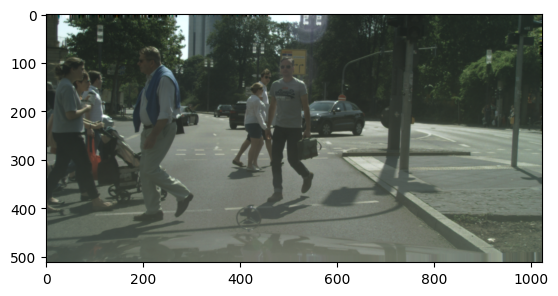

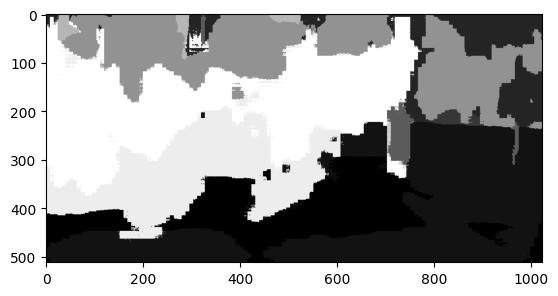

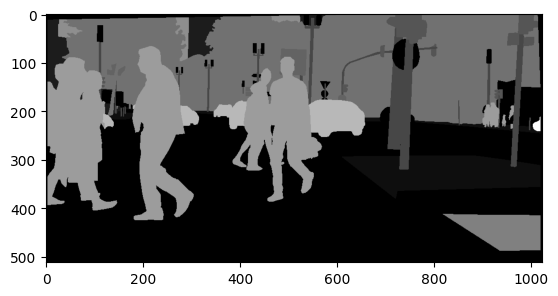

Accuracy: 0.15243005708145435


In [51]:
LOAD_PATH = "saved/autosave/good-firebrand-29-GTA5/epoch28.pth" # "saved/4_4-DSA-FDA.pth"; "saved/4_4-DSB-FDA.pth"

torch.cuda.empty_cache()
test_net = BiSeNetV2(NUM_CLASSES, output_aux = True)
test_net.to(DEVICE)

test_client = Client(f"test_client", DSB_test, test_net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, autosave=False)
test_client.load_model(LOAD_PATH)

accuracy = test_client.test()
print(f"Accuracy: {accuracy['Mean IoU']}")

## 5. Federated self-training using pseudo-labels
Now that we have pre-trained a model, we can use that as a "teacher" model to generate pseudo-labels that will be used as ground-truth labels by a "student" model for training. 

To do so, we created a new class, `StudentClient` (available at `clients.student`), which is a child of the `Client` class. In addition to the parent class, it can store the teacher model and perform a forward pass on that model for each batch of images used for training and will use the pseudo labels obtained from the teacher model, instead of the real labels, to calcuate the losses.

We initially set both teacher and student model as the pre-trained model obtained in [step 4](#step4) and assign them to student clients for each partition and split of Cityscapes described in [step 3](#step3):

In [7]:
teacher_model = student_model = BiSeNetV2(NUM_CLASSES, output_aux = True).to(DEVICE)

if HETEROGENEOUS:
    split_A = heterogeneous_split(DSA_train, NUM_CLIENTS)
    split_B = heterogeneous_split(DSB_train, NUM_CLIENTS)
    
else:
    split_A = uniform_split(DSA_train, NUM_CLIENTS)
    split_B = uniform_split(DSB_train, NUM_CLIENTS)

Referring to the project paper, we follow three strategies:
1. Teacher model never updated
1. Teacher model updated at beginnign of each round
1. Teacher model updatet every T rounds

These strategies are managed by the `Server` class: if we don't pass T or we pass `T=0`, the server will never update the teacher model of the clients. If we pass `T=1`, the server will update the teacher model every round, setting it to its own model. If we pass `T>1`, the server will update the teacher model T rounds, again with its own model.

In [16]:
T = 0

Now we can begin the self-training with pseudo-labels, running different experiments loading the best checkpoints from [step 4](#step4), first without FDA and then with FDA, as described in the project paper.

For sake of simplicity and readability, we wrote the code just one time and ran it different times manually loading the checkpoints.

In [ ]:
# Federated Self Training - Dataset A

LOAD_PATH = "saved/4_4-DSA-FDA.pth" # "saved/4_2-GTA5.pth"; "saved/4_4-DSA-FDA.pth";

clients = []
for i, images_paths in tqdm(enumerate(split_A)):
    client_dataset = Cityscapes(CITYSCAPES_PATH, images_paths, transform=train_transform, cl19=True)
    client = StudentClient(f"c{i}", client_dataset, student_model, BATCH_SIZE_FLSS, DEVICE, NUM_EPOCHS_FLSS, hypers_flss, autosave=False, teacher=teacher_model)

    client.load_teacher(LOAD_PATH)
    client.load_model(LOAD_PATH)

    clients.append(client)

wandb_config_flss["dataset"] = "Dataset A"
wandb_config_flss["T"] = T
wandb_config_flss["checkpoint"] = "4.4"
wandb.init(project="FST", config=wandb_config_flss)
FST_server = Server(f"{wandb.run.name}-FST", teacher_model, DEVICE, clients)

# Loading teacher model
FST_server.load_model(LOAD_PATH)

FST_server.run_fedAvg(NUM_ROUNDS, T, CLIENTS_PER_ROUND)
wandb.finish()

We follow the same procedure for Dataset B:

In [ ]:
# Federated Self Training - Dataset B


LOAD_PATH = "saved/4_4-DSB-FDA.pth" # "saved/4_2-GTA5.pth"; "saved/4_4-DSB-FDA.pth";

clients = []
for i, images_paths in tqdm(enumerate(split_B)):
    client_dataset = Cityscapes(CITYSCAPES_PATH, images_paths, transform=train_transform, cl19=True)
    client = StudentClient(f"c{i}", client_dataset, student_model, BATCH_SIZE_FLSS, DEVICE, NUM_EPOCHS_FLSS, hypers_flss, autosave=False, teacher=teacher_model)

    # Loading corresponding checkpoint (splits B.I or B.II)
    client.load_teacher(LOAD_PATH)
    client.load_model(LOAD_PATH)

    clients.append(client)

wandb_config_flss["dataset"] = "Dataset B"
wandb_config_flss["T"] = T
wandb_config_flss["checkpoint"] = "4.4"
wandb.init(project="FST", config=wandb_config_flss)
FST_server = Server(f"{wandb.run.name}-FST", teacher_model, DEVICE, clients)

# Loading teacher model
FST_server.load_model(LOAD_PATH)

FST_server.run_fedAvg(NUM_ROUNDS, T, CLIENTS_PER_ROUND)
wandb.finish()

The following test is performed considering a network trained with the heterogeneous split of partition A with FDA, using the Cityscapes test dataset of partition A:

In [ ]:
'''
LOAD PATHS: (heterogeneous)
"saved/A-NoFDA-T0.pth"
"saved/A-NoFDA-T1.pth"
"saved/A-NoFDA-T5.pth"
"saved/A-FDA-T0.pth"
"saved/A-FDA-T1.pth"
"saved/A-FDA-T5.pth"
"saved/B-NoFDA-T0.pth"
"saved/B-NoFDA-T1.pth"
"saved/B-NoFDA-T5.pth"
"saved/B-FDA-T0.pth"
"saved/B-FDA-T1.pth"
"saved/B-FDA-T5.pth"

'''

LOAD_PATH = "saved/A-NoFDA-T0.pth"

torch.cuda.empty_cache()
test_net = BiSeNetV2(NUM_CLASSES, output_aux = True)
test_net.to(DEVICE)

test_client = Client(f"test_client", DSA_test, test_net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, autosave=False)
test_client.load_model(LOAD_PATH)

accuracy = test_client.test()
print(f"Accuracy: {accuracy['Mean IoU']}")

In [ ]:
LOAD_PATH = "saved/B-FDA-T1.pth"

torch.cuda.empty_cache()
test_net = BiSeNetV2(NUM_CLASSES, output_aux = True)
test_net.to(DEVICE)

test_client = Client(f"test_client", DSB_test, test_net, BATCH_SIZE, DEVICE, NUM_EPOCHS, hypers, autosave=False)
test_client.load_model(LOAD_PATH)


image, GT = test_client.dataset[0]

images = torch.stack((image, image), dim=0)
images = images.to(DEVICE)
outputs = test_client.model(images)

_, prediction = outputs[0].max(dim=1)

prediction = prediction[0]


test_client.plot_sample(prediction, image, GT)